Kudos - **https://www.kaggle.com/sreshta140/is-it-authentic-or-not/notebook**

![](https://quicksilver.scoopwhoop.com/unsafe/960x500/center/https://s3.scoopwhoop.com/anj/chb/267436620.jpg)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from prettytable import PrettyTable

In [3]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


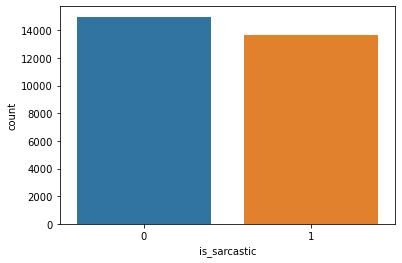

In [4]:
sns.countplot(df['is_sarcastic'])

In [5]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

**Data Cleaning**

In [6]:

def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re'"," are", phrase)
    phrase = re.sub(r"\'s"," is", phrase)
    phrase = re.sub(r"\'ll"," will", phrase)
    phrase = re.sub(r"\'d"," would", phrase)
    phrase = re.sub(r"\'t"," not", phrase)
    phrase = re.sub(r"\'ve"," have", phrase)
    phrase = re.sub(r"\'m"," am", phrase)
    
    return phrase

In [7]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
stop = set(stopwords.words('english'))
len(stop)

179

In [9]:
cleaned_title = []

for sentance in tqdm(df['headline'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())

100%|██████████| 28619/28619 [00:08<00:00, 3552.01it/s]


In [10]:
df['headline'] = cleaned_title

**SOME BASIC EDA**

In [11]:
from wordcloud import WordCloud,STOPWORDS

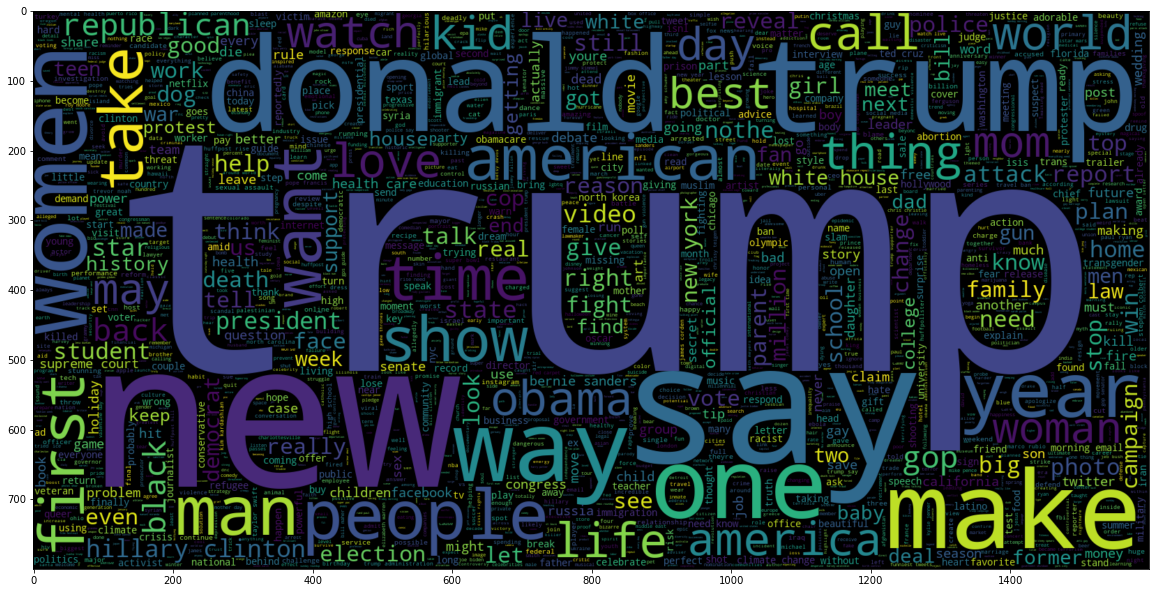

In [12]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

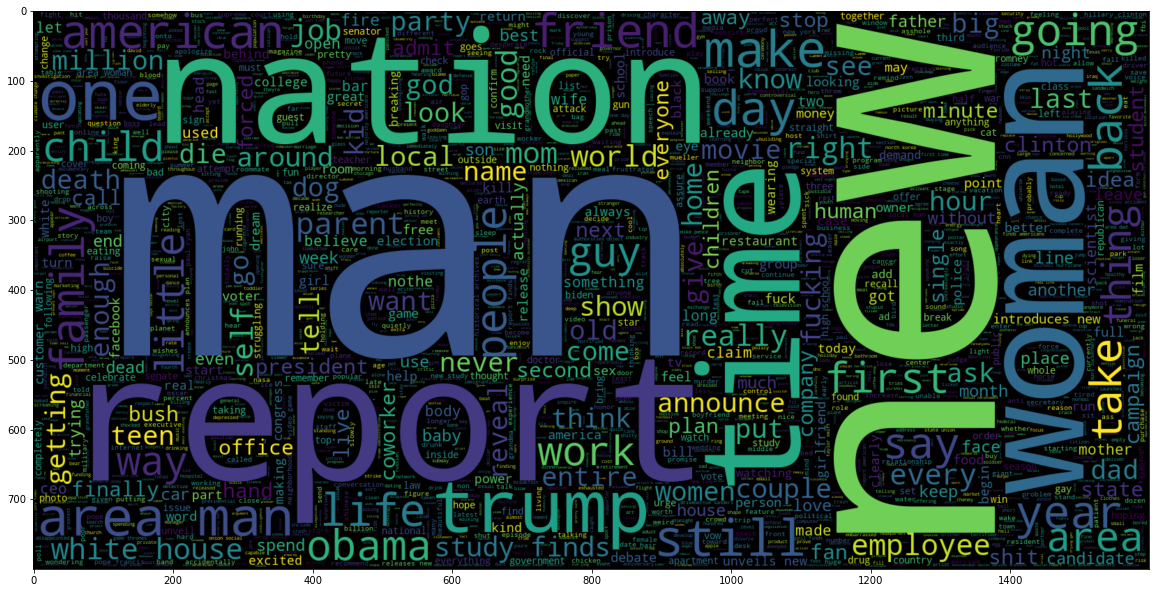

In [13]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
import plotly.offline as pyoff
import plotly.graph_objs as go
from nltk.util import ngrams
import re
import unicodedata
import nltk

In [15]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

**Finding Bi-grams and Tri-grams for Sarcastic headlines**

In [16]:
sarcastic_words = basic_clean(''.join(str(df[df['is_sarcastic']==1]['headline'].tolist())))

In [17]:
bigram_sarcastic=(pd.Series(nltk.ngrams(sarcastic_words, 2)).value_counts())[:30]

bigram_sarcastic=pd.DataFrame(bigram_sarcastic)

In [18]:
bigram_sarcastic['idx']=bigram_sarcastic.index

In [19]:
bigram_sarcastic['idx'] = bigram_sarcastic.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+')',axis=1)

In [20]:
plot_data = [
    go.Bar(
        x=bigram_sarcastic['idx'],
        y=bigram_sarcastic[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 bi-grams from Sarcastic News',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [61]:
plot_data = [
    go.Bar(
        x=bigram_sarcastic[0],
        y=bigram_sarcastic['idx'],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 bi-grams from Sarcastic News',
        yaxis_title='bi-gram',
        xaxis_title='Count',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [21]:
trigram_sarcastic=(pd.Series(nltk.ngrams(sarcastic_words, 3)).value_counts())[:30]

trigram_sarcastic=pd.DataFrame(trigram_sarcastic)

trigram_sarcastic

,0
"(new, study, find)",35
"(new, york, time)",17
"(kim, jong, un)",15
"(nation, regularly, happens)",12
"(poll, find, american)",12
"(say, nation, regularly)",12
"(way, prevent, say)",12
"(prevent, say, nation)",12
"(new, report, find)",11
"(study, find, human)",9


In [22]:
trigram_sarcastic['idx']=trigram_sarcastic.index

trigram_sarcastic['idx'] = trigram_sarcastic.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+', ' + x['idx'][2]+')',axis=1)

In [23]:
plot_data = [
    go.Bar(
        x=trigram_sarcastic['idx'],
        y=trigram_sarcastic[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 tri-grams from Sarcastic News',
        yaxis_title='Count',
        xaxis_title='tri-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

**Bi-grams and Tri-grams for non-sarcastic headlines**

In [24]:
not_sarcasm = basic_clean(''.join(str(df[df['is_sarcastic']==0]['headline'].tolist())))

In [25]:
bigram_notsarcastic=(pd.Series(nltk.ngrams(not_sarcasm, 2)).value_counts())[:30]

bigram_notsarcastic=pd.DataFrame(bigram_notsarcastic)

bigram_notsarcastic

,0
"(donald, trump)",445
"(hillary, clinton)",141
"(new, york)",91
"(white, house)",86
"(supreme, court)",75
"(bernie, sander)",64
"(climate, change)",59
"(health, care)",59
"(morning, email)",56
"(need, know)",54


In [26]:
bigram_notsarcastic['idx']=bigram_notsarcastic.index

bigram_notsarcastic['idx'] = bigram_notsarcastic.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+')',axis=1)

In [27]:
plot_data = [
    go.Bar(
        x=bigram_notsarcastic['idx'],
        y=bigram_notsarcastic[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 bi-grams from Not Sarcasm News',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [28]:
trigram_notsarcastic=(pd.Series(nltk.ngrams(not_sarcasm, 3)).value_counts())[:30]

trigram_notsarcastic=pd.DataFrame(trigram_notsarcastic)

trigram_notsarcastic['idx']=trigram_notsarcastic.index

trigram_notsarcastic['idx'] = trigram_notsarcastic.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+', ' + x['idx'][2]+')',axis=1)

In [29]:
plot_data = [
    go.Bar(
        x=trigram_notsarcastic['idx'],
        y=trigram_notsarcastic[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 tri-grams from Non Sarcastic News',
        yaxis_title='Count',
        xaxis_title='tri-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Word 2 Vec

In [30]:
import gensim

First we tokenize the words of the entire corpus. 

In [31]:
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df['headline'].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

Model Building

In [32]:
w2v_model = gensim.models.Word2Vec(sentences=X, size=150, window=5, min_count=2)

Naive observations

In [33]:
w2v_model.wv.most_similar(positive = 'trump')

[('jr', 0.9948710203170776),
 ('colbert', 0.9939351677894592),
 ('maher', 0.9938793182373047),
 ('apologize', 0.993852972984314),
 ('meyers', 0.9938075542449951),
 ('noah', 0.9935864806175232),
 ('trolls', 0.9935044050216675),
 ('endorsement', 0.9932888150215149),
 ('bolton', 0.9931567311286926),
 ('spoof', 0.9931138753890991)]

In [34]:
w2v_model.wv.most_similar(positive = 'research')

[('show', 0.9997357726097107),
 ('michael', 0.9997334480285645),
 ('power', 0.9997326135635376),
 ('may', 0.9997323751449585),
 ('use', 0.9997311234474182),
 ('wants', 0.9997265338897705),
 ('company', 0.9997257590293884),
 ('end', 0.9997256994247437),
 ('story', 0.9997245669364929),
 ('american', 0.9997243881225586)]

In [35]:
w2v_model.wv.most_similar(positive = 'study')

[('poll', 0.9994221925735474),
 ('americans', 0.9992232322692871),
 ('report', 0.9992097020149231),
 ('york', 0.9991714358329773),
 ('humans', 0.9991346597671509),
 ('majority', 0.9991312623023987),
 ('new', 0.9991239905357361),
 ('introduces', 0.9990896582603455),
 ('unveils', 0.9990448951721191),
 ('releases', 0.9989938735961914)]

In [36]:
w2v_model.wv.similarity('trump', 'fake')

0.99130875

No surprise

In [37]:
w2v_model.wv.doesnt_match(['trump', 'hillary', 'pence'])

/opt/conda/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'hillary'

**No surprise ** 2**

In [38]:
w2v_model.wv.most_similar(positive = ['research','study'], negative=['harvard'], topn=3)

[('york', 0.9957239627838135),
 ('poll', 0.9956259727478027),
 ('majority', 0.9954084157943726)]

'Research' is to what as 'study' is to 'harvard'

**Model Building**

In [39]:
X = df['headline']
y = df['is_sarcastic']

In [40]:
from sklearn.model_selection import train_test_split
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [41]:
X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, test_size=0.1, random_state=42)

In [42]:
tf_idf=TfidfVectorizer(min_df=4,use_idf=True,ngram_range=(1,3))
tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

In [43]:
from sklearn.naive_bayes import MultinomialNB

In [44]:
alpha_set=[0.0001,0.001,0.01,0.1,1,10,100,1000]

Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []


for i in alpha_set:
    naive_b=MultinomialNB(alpha=i)
    naive_b.fit(Train_TFIDF, y_train)
    Train_y_pred =  naive_b.predict(Train_TFIDF)
    Train_AUC_TFIDF.append(roc_auc_score(y_train,Train_y_pred))
    CrossVal_y_pred =  naive_b.predict(CrossVal_TFIDF)
    CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [45]:
Alpha_set=[]
for i in range(len(alpha_set)):
    Alpha_set.append(np.math.log(alpha_set[i]))

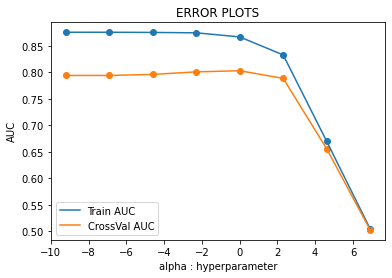

In [46]:
plt.plot(Alpha_set, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_TFIDF)
plt.plot(Alpha_set, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

No clear signs of overfitting observed

In [47]:
optimal_alpha=alpha_set[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_alpha)

1


In [48]:
Classifier2 = MultinomialNB(alpha=optimal_alpha)
Classifier2.fit(Train_TFIDF, y_train)

MultinomialNB(alpha=1)

In [49]:
from sklearn.metrics import accuracy_score
print ("Accuracy on Train is: ", accuracy_score(y_train,Classifier2.predict(Train_TFIDF)))

print ("Accuracy on Test is: ", accuracy_score(y_test,Classifier2.predict(Test_TFIDF)))

Accuracy on Train is:  0.8675639532375653
Accuracy on Test is:  0.8067784765897974


**This accuracy is pretty good for a model built on simple ML methods**

In [50]:
from sklearn import metrics
print(metrics.classification_report(y_test,Classifier2.predict(Test_TFIDF)))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1506
           1       0.80      0.78      0.79      1356

    accuracy                           0.81      2862
   macro avg       0.81      0.81      0.81      2862
weighted avg       0.81      0.81      0.81      2862



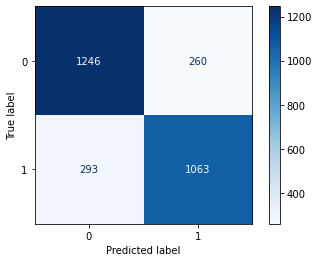

In [51]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(Classifier2, Test_TFIDF, y_test ,display_labels=['0','1'],cmap="Blues",values_format = '')

**Logistic Regression**

In [52]:
tf_idf=TfidfVectorizer(min_df=4,use_idf=True,ngram_range=(1,2))
tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in c:
    logreg = LogisticRegression(C=i,penalty='l2')
    logreg.fit(Train_TFIDF, y_train)
    Train_y_pred =  logreg.predict(Train_TFIDF)
    Train_AUC_TFIDF.append(roc_auc_score(y_train ,Train_y_pred))
    CrossVal_y_pred =  logreg.predict(CrossVal_TFIDF)
    CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [55]:
C=[]
for i in range(len(c)):
    C.append(np.math.log(c[i]))

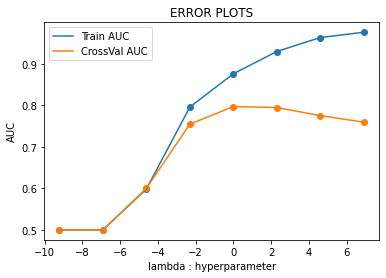

In [56]:
plt.plot(C, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF)
plt.plot(C, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Both the plots look similar till lambda = 0, after which the the model starts overfitting to the train data.

In [57]:
optimal_inverse_lambda=c[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(pow(optimal_inverse_lambda,-1))

1.0


In [58]:
Classifier=LogisticRegression(C=optimal_inverse_lambda,penalty='l2')
Classifier.fit(Train_TFIDF, y_train)

LogisticRegression(C=1)

In [59]:
print ("Accuracy on Train is: ", accuracy_score(y_train,Classifier.predict(Train_TFIDF)))
print ("Accuracy on Test is: ", accuracy_score(y_test,Classifier.predict(Test_TFIDF)))

Accuracy on Train is:  0.877399594495492
Accuracy on Test is:  0.8085255066387141


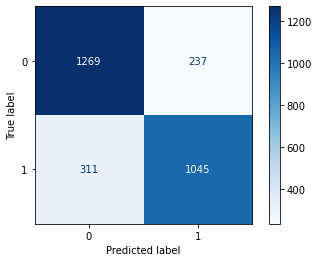

In [60]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(Classifier, Test_TFIDF, y_test ,display_labels=['0','1'],cmap="Blues",values_format = '')